# imports

In [1]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import numpy as np

# input data

In [2]:
# funtions to preprocess data
def mapping_2_df(actual_df,predicted_df,hit_threadhold = 0.5):
    result = pd.merge(actual_df,predicted_df, on=['video_id','action_id'],how='left',suffixes=('_g', '_p'))
    result['diff_start'] = abs(result['start_g']-result['start_p'])
    result['diff_end'] = abs(result['end_g']-result['end_p'])
    # filter out condition
    result['is_filtered'] = (result['diff_start'] >10) | (result['diff_end']>10)
    # calculate intersection time
    result['i_start'] = np.where(~result['is_filtered'], result[['start_g', 'start_p']].max(axis=1), np.nan)
    result['i_end'] = np.where(~result['is_filtered'], result[['end_g', 'end_p']].min(axis=1), np.nan)
    # calculate union time
    result['u_start'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['start_g', 'start_p']].min(axis=1), np.nan)
    result['u_end'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['end_g', 'end_p']].max(axis=1), np.nan)
    # calculate IoU
    result['intersection'] = result['i_end'] - result['i_start']
    result['union'] = result['u_end'] - result['u_start']
    result['iou'] = np.where(~result['is_filtered'] 
                             & result['union']>0,result['intersection']/result['union'],0)
    # flag hit base on threadhold
    result['is_hit'] = np.where(result['iou'] >= hit_threadhold,1,0)
    return result





In [23]:
# mapping df base on video_id and start
def mapping_2_df_by_time(actual_df,predicted_df,hit_threadhold = 0.5,time_threadhold = 10):
    '''
        mapping 2 df by video_id
            after that, add filter column with gap 10s from the contest
        
    '''
    result = pd.merge(actual_df,predicted_df, on=['video_id'],how='left',suffixes=('_g', '_p'))
    result['diff_start'] = abs(result['start_g']-result['start_p'])
    result['diff_end'] = abs(result['end_g']-result['end_p'])
    # filter out condition
    result['is_filtered'] = (result['diff_start'] >time_threadhold) | (result['diff_end']>time_threadhold)
    result = result.loc[~result['is_filtered']]
    # calculate intersection time
    result['i_start'] = np.where(~result['is_filtered'], result[['start_g', 'start_p']].max(axis=1), np.nan)
    result['i_end'] = np.where(~result['is_filtered'], result[['end_g', 'end_p']].min(axis=1), np.nan)
    # calculate union time
    result['u_start'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['start_g', 'start_p']].min(axis=1), np.nan)
    result['u_end'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['end_g', 'end_p']].max(axis=1), np.nan)
    # calculate IoU
    result['intersection'] = result['i_end'] - result['i_start']
    result['union'] = result['u_end'] - result['u_start']
    result['iou'] = np.where(~result['is_filtered'] 
                             & result['union']>0,result['intersection']/result['union'],0)
    # flag hit base on threadhold
    result['is_hit'] = np.where(result['iou'] >= hit_threadhold,1,0)
    result = result.sort_values(['iou'],ascending=False).drop_duplicates(['video_id','action_id_p'])
    # result = result.loc[result['is_hit']==1]

    # remap with actual df
    temp = actual_df[['video_id','action_id']]\
            .merge(
                result[['video_id','action_id_g','action_id_p','iou']]                    
                ,left_on =['video_id','action_id']
                ,right_on=['video_id','action_id_g']
                ,how='left'
                ,suffixes=('_g', '_p'))
    temp['action_id_p'] = temp['action_id_p'].fillna(-1)
    action_label = pd.read_csv("data/Distracted_Activity_Class_definition.txt",sep=',')

    action_id_to_label = action_label.set_index('action_id')['Label'].to_dict()
    # display(action_label)
    # Map action_ids to labels in the DataFrame
    temp['action_label_g'] = temp['action_id'].map(action_id_to_label)
    temp['action_label_p'] = temp['action_id_p'].map(action_id_to_label)
    temp['action_label_g'] = temp['action_label_g'].fillna("-1")
    temp['action_label_p'] = temp['action_label_p'].fillna("-1")
    temp['iou'] = temp['iou'].fillna(0)
    return temp



# calculate and plot the confustion matrix

****************************************************************************************************
A2_submission_old.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou:  0.7012846009201423
hit = 128 | count = 150 | hit/count = 0.8533333333333334
Creating confusion matrix
****************************************************************************************************
final_submission.txt
****************************************************************************************************
calculated result vs ground truth:
avg iou:  0.7319503746234496
hit = 134 | count = 150 | hit/count = 0.8933333333333333
Creating confusion matrix


/home/quang/miniconda3/envs/AIcity_VTCC/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/quang/miniconda3/envs/AIcity_VTCC/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/quang/miniconda3/envs/AIcity_VTCC/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/quang/miniconda3/envs/AIcity_VTCC/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version.

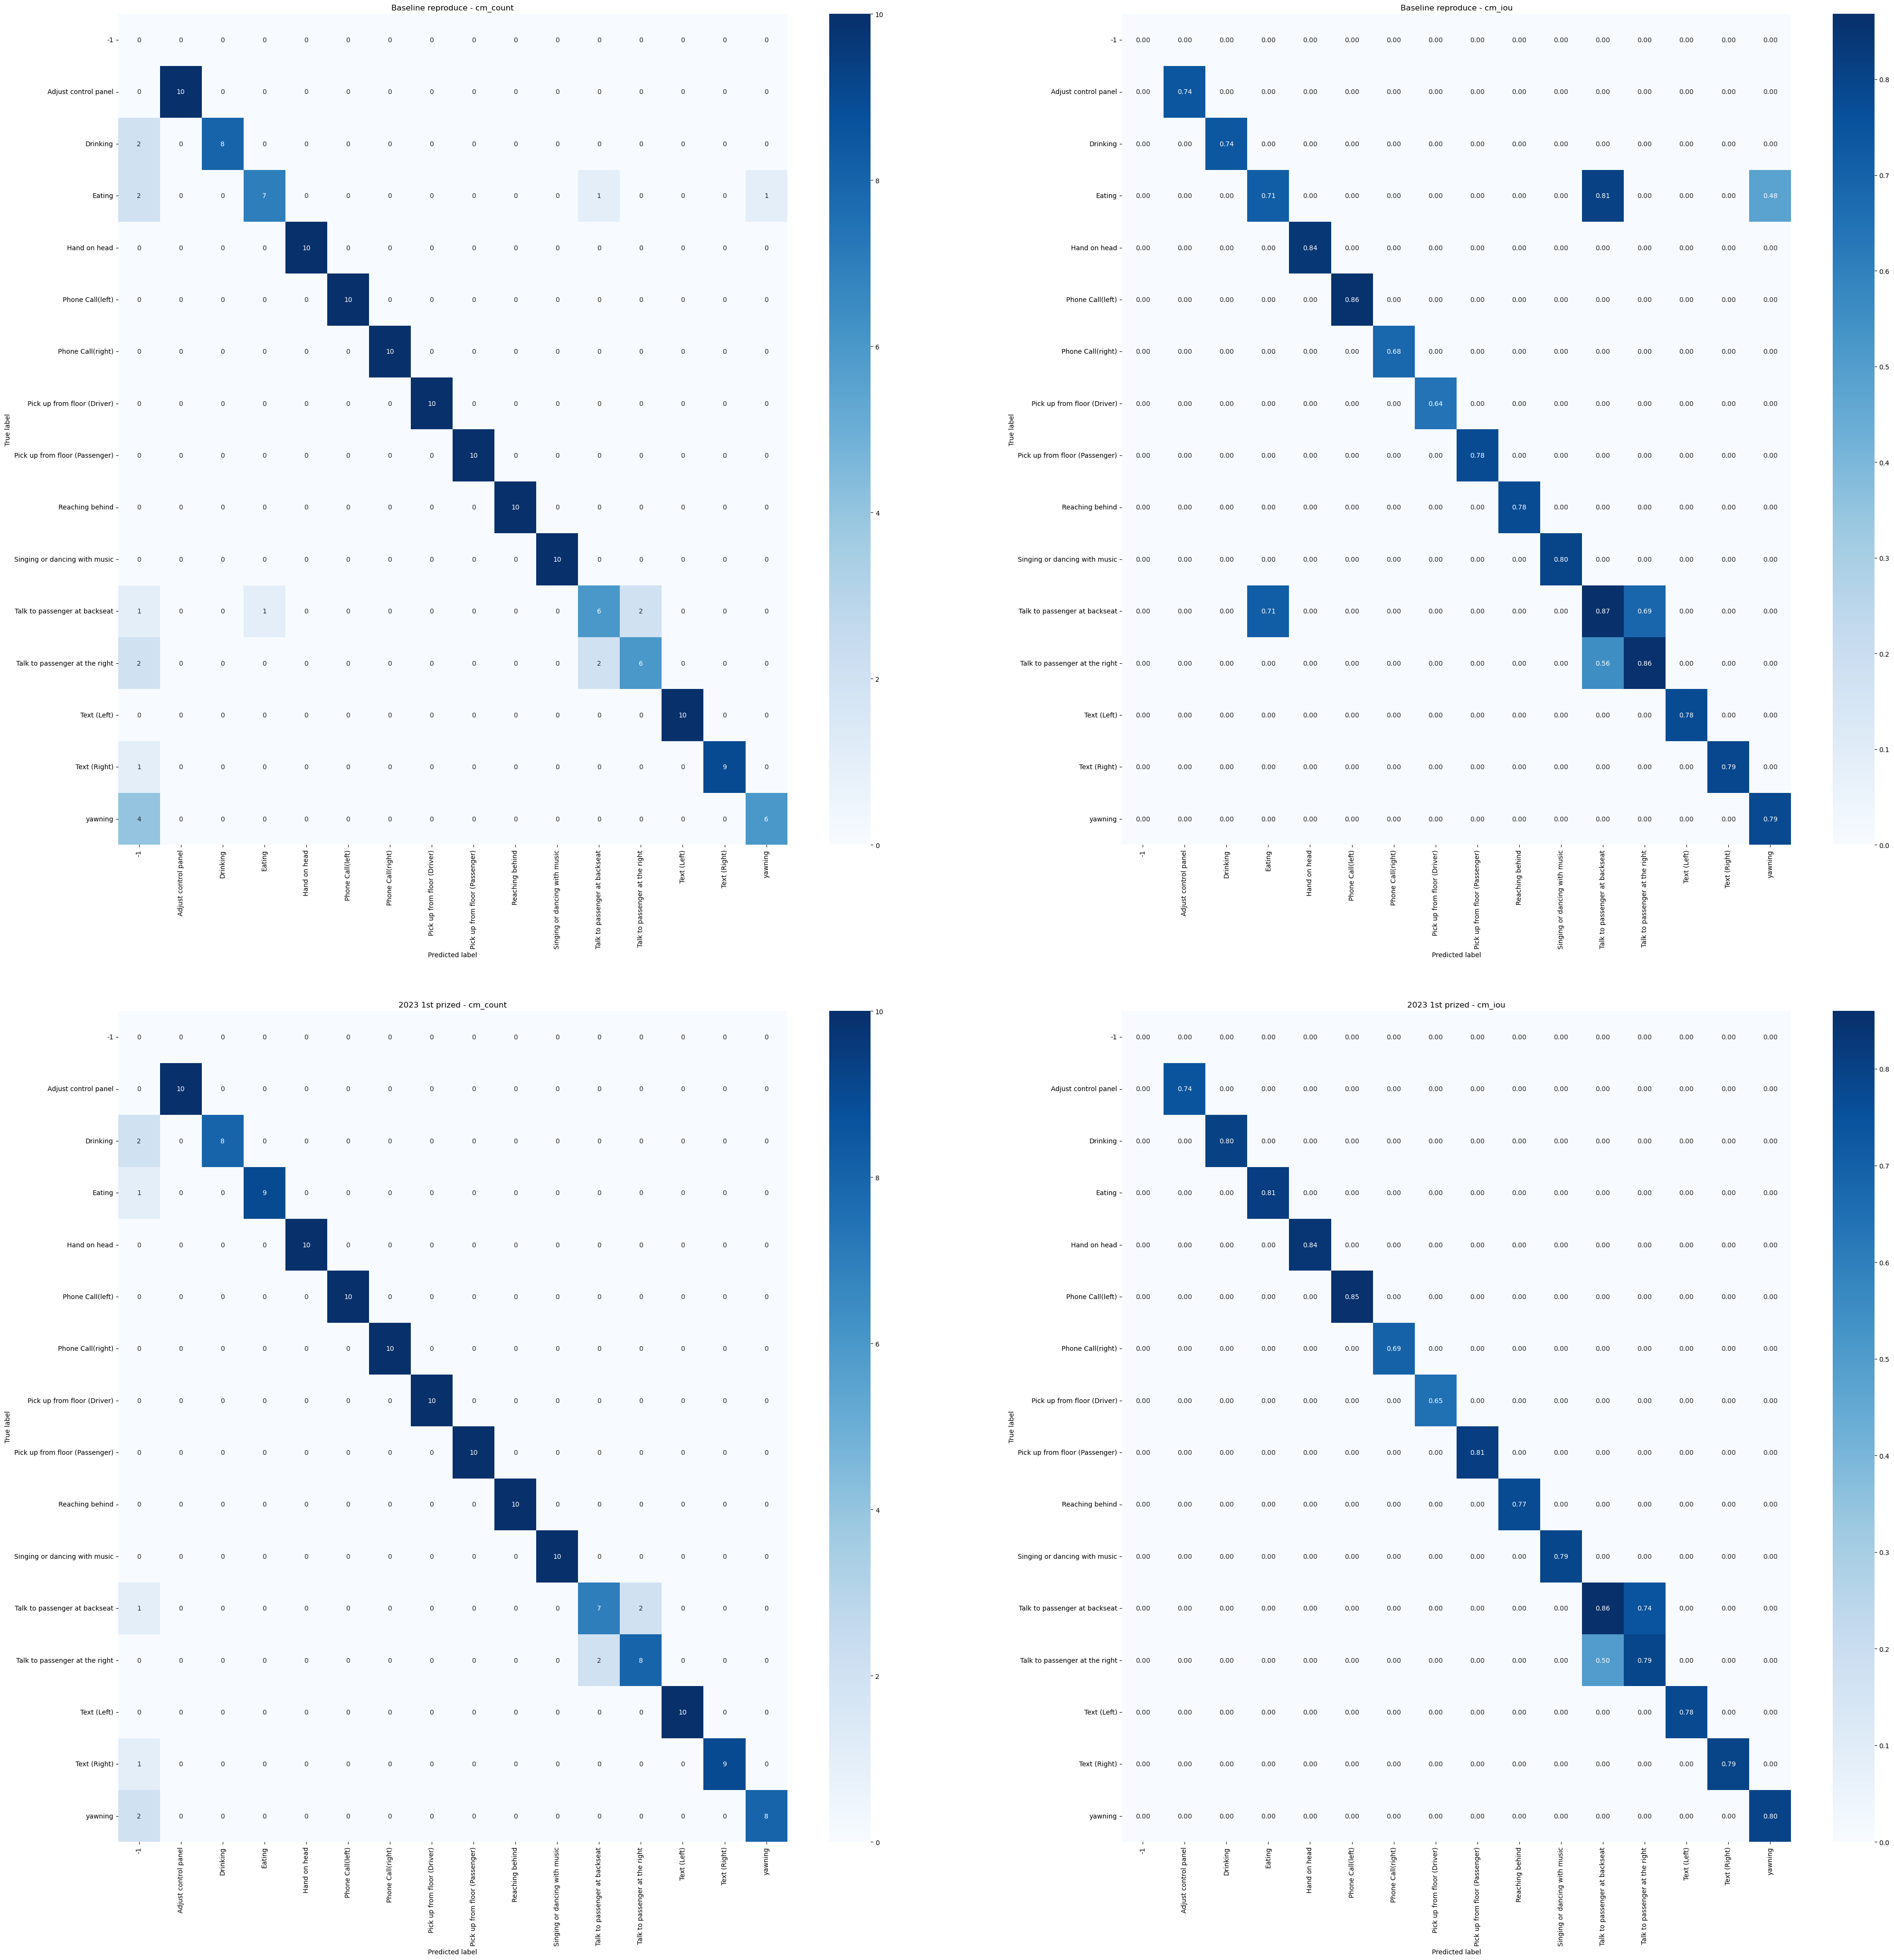

In [37]:


def cal_cm(y_true, y_pred):
    # add unreconized label 
    unique_labels = np.append(y_true.unique(), "-1")
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Convert to DataFrame for easier plotting
    # pd_df of indexes for columns and labels
    cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

    return cm_df

def plot_confusion_matrices(confusion_matrices_dict,size=25):
    fortmat_code = {'cm_count':'d','cm_iou':'.2f'}
    num_matrices = len(confusion_matrices_dict)
    # Extracting the keys from the dictionary and getting the number of metrics
    metrics = list(confusion_matrices_dict.values())[0].keys()
    num_metrics = len(metrics)

    # Create a figure with subplots based on the number of confusion matrices
    fig, axes = plt.subplots(num_matrices, num_metrics, figsize=(size * num_metrics, size * num_matrices))
    
    # If there's only one confusion matrix, make sure axes is a list
    if num_matrices == 1:
        axes = [axes]

    # Plot each confusion matrix
    for i, (title, metric_dict) in enumerate(confusion_matrices_dict.items()):
        for j, (metric_name, cm_df) in enumerate(metric_dict.items()):
            cm_df.sort_index(axis=0, inplace=True)
            cm_df.sort_index(axis=1, inplace=True)
            sns.heatmap(cm_df, annot=True, ax=axes[i, j], fmt=fortmat_code[metric_name], cmap='Blues',
                        xticklabels=cm_df.columns, yticklabels=cm_df.index)
            axes[i, j].set_title(f"{title} - {metric_name}")
            axes[i, j].set_ylabel('True label')
            axes[i, j].set_xlabel('Predicted label')

    # Show the plot
    plt.show()


def benchmark_submit(df_ground_truth, csv_file_path = 'A2_submission_old.txt'):
    print("*"*100)
    print(csv_file_path)
    print("*"*100)
    df_baseline = pd.read_csv(csv_file_path,sep=' ')
    df_baseline.columns = ['video_id', 'action_id','start','end']

    print("calculated result vs ground truth:") 
    preprocess = mapping_2_df(df_ground_truth,df_baseline)
    # display(preprocess)
    print("avg iou: ",preprocess['iou'].mean())
    print(f"hit = {preprocess['is_hit'].sum()} | count = {preprocess['is_hit'].count()} | hit/count = {preprocess['is_hit'].sum()/preprocess['is_hit'].count()}")

    print("Creating confusion matrix")
    test = mapping_2_df_by_time(df_ground_truth,df_baseline)
    # print(test.groupby('video_id').nunique())
    # display(test)
    result = {}
    result['cm_count'] = cal_cm(test['action_label_g'],test['action_label_p'])
    # result['iou'] = test['iou']
    result['cm_iou'] = pd.pivot_table(test,values='iou',index='action_label_g',columns='action_label_p',aggfunc='mean',fill_value=0)
    # Create a new DataFrame for the row to be added
    new_row = pd.DataFrame(data={col: [0] for col in result['cm_iou'].columns}, index=['-1'])

    # Append the new row to the pivot table
    result['cm_iou'] = pd.concat([result['cm_iou'], new_row])
    return result
    
# Load ground truth from Excel file
excel_file_path = 'data/A2/ground_truth_A2_manual_.xlsx'
df_ground_truth = pd.read_excel(excel_file_path,sheet_name='ground_truth_submit')

confusion_matrices_dict = {'Baseline reproduce': benchmark_submit(df_ground_truth,'A2_submission_old.txt'),
                           '2023 1st prized': benchmark_submit(df_ground_truth,'final_submission.txt')}
# Plot the confusion matrices
plot_confusion_matrices(confusion_matrices_dict)

action_label_p,-1,Adjust control panel,Drinking,Eating,Hand on head,Phone Call(left),Phone Call(right),Pick up from floor (Driver),Pick up from floor (Passenger),Reaching behind,Singing or dancing with music,Talk to passenger at backseat,Talk to passenger at the right,Text (Left),Text (Right),yawning
action_label_g,,,,,,,,,,,,,,,,
Adjust control panel,,0.739402,,,,,,,,,,,,,,
Drinking,0.0,,0.738294,,,,,,,,,,,,,
Eating,0.0,,,0.713346,,,,,,,,0.809524,,,,0.48
Hand on head,,,,,0.841715,,,,,,,,,,,
Phone Call(left),,,,,,0.859458,,,,,,,,,,
Phone Call(right),,,,,,,0.684979,,,,,,,,,
Pick up from floor (Driver),,,,,,,,0.643561,,,,,,,,
Pick up from floor (Passenger),,,,,,,,,0.777143,,,,,,,
Reaching behind,,,,,,,,,,0.77938,,,,,,


array(['Singing or dancing with music', 'Hand on head',
       'Adjust control panel', 'Eating', 'Talk to passenger at the right',
       'Talk to passenger at backseat', 'Pick up from floor (Driver)',
       'Text (Right)', 'Reaching behind', 'Phone Call(left)',
       'Text (Left)', 'Phone Call(right)',
       'Pick up from floor (Passenger)', 'Drinking', 'yawning', '-1'],
      dtype=object)